<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#DNN" data-toc-modified-id="DNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DNN</a></span></li><li><span><a href="#Quantile-regressor" data-toc-modified-id="Quantile-regressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Quantile regressor</a></span></li><li><span><a href="#Boostrap" data-toc-modified-id="Boostrap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Boostrap</a></span></li><li><span><a href="#Compare" data-toc-modified-id="Compare-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compare</a></span></li></ul></div>

# Prediction interval 

## Intro

In this notebook we present 3 different ways of estimate predictions intervals in machine learnings. We adopt pragmatic approach in how to use the models and highlight the main concepts of each methodology. The details on how it works and the models implamenations is outside of the scope this notebook. Please rely on the references and academic pares from that. 


The first conept we want to dicuss is the cocept of prediction intervals and confidence intervals. below is the main diferences:

* Confidence Intervals  
    * Take sinto account data dispersion
    * Based on data and not model. 
    * Usually measure uncertainty in determination of the statistics of a population like the mean.

> PS: code (python) and discusison to help with plot ci and pi together:
> * https://towardsdatascience.com/how-confidence-and-prediction-intervals-work-4592019576d8
> * https://towardsdatascience.com/confidence-intervals-vs-prediction-intervals-7b296ae58745

* Prediciton Intervals
    * Takes into account uncertainty introduced by the models
    * Prediction intervals ususlay is not constant acroos $X$ and certainly $PI > CI$

1. What is prediction intervals
    * range size vs coverage trade offs 
    * source of uncertainty: models, data and bayes
    * difference between prediction intervals and confidence intervals
        
1. Why it is important 

1. Summary of what. Discuss pros and cons of each approach  
    * DNN 
    * Quantile approaches 
    * Bootstrap 
    
    
Overview:

1. First section: Linear data and complex data generation
1. Second part: Introduce all models using linear data and compare them with linear regerssion
1. 3rd part: Compare all models using complex data 

In [2]:
import IPython
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
# import keras
# from keras import backend as K

print(tf.__version__)

2.6.2


In [2]:
from utils import qd_objective, mpiw_pct, mpiw, picp,mpiw_pct_metric, mpiw_metric,picp_metric

ModuleNotFoundError: No module named 'utils'

In [16]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 458.3 MB 32 kB/s              
     |████████████████████████████████| 4.6 MB 10.2 MB/s            
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 462 kB 10.9 MB/s            
     |████████████████████████████████| 5.6 MB 7.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.0 MB 8.2 MB/s            
  Using cached protobuf-3.19.4-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 132 kB 10.2 MB/s            
     |███████████████████████████

## Data

* Linear data for simplicity and comapre with linera reression
* Non linear qith hetredosticity data to compare all approaches

2 std: 0.50


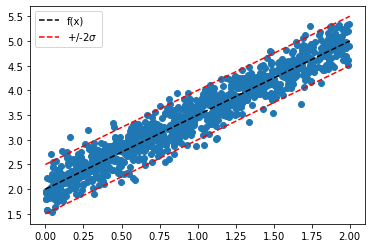

In [25]:
# create some data
n_samples = 1000

X = np.random.uniform(low=0.,high=2.,size=(n_samples,1))

_sigma = 0.25
noise = np.random.normal(loc=0.,scale=_sigma,size=(n_samples,1))

a = 1.5
b = 2.0

f_x = a*X + b  
y =  f_x + noise

#y = y.reshape([-1,1])/5.  # Is this important? Divide by 5 ? Why did he do it?
y = y.reshape([-1,1])  # Is this important? Divide by 5 ? Why did he do it?

noise.shape
X_train = X.reshape(-1)
y_train = y.reshape(-1)

X_train.shape
y_train.shape

y_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(0.0,2,100) # for evaluation plots

plt.scatter(X_train,y_train[:,0])

f_x = a*x_grid + b  

_delta = 2.0*_sigma  # 2 sigmas

print(f"2 std: {_delta:.2f}")

plt.plot(x_grid, f_x, 'k--',label='f(x)'); # regression line
plt.plot(x_grid, f_x + _delta, 'r--', label='+/-2$\sigma$'); # upper boundary prediction
plt.plot(x_grid, f_x - _delta, 'r--'); # lower boundary prediction
plt.legend();

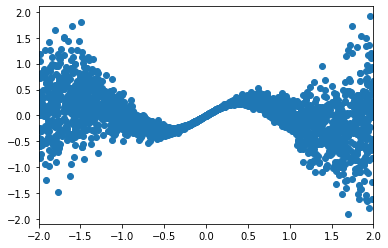

In [30]:
# create some data
n_samples = 2500
X = np.random.uniform(low=-2.,high=2.,size=(n_samples,1))
y = 1.5*np.sin(np.pi*X[:,0]) + np.random.normal(loc=0.,scale=1.*np.power(X[:,0],2))

# nrmalization
y = y.reshape([-1,1])/5.

X_train = X.reshape(-1)
y_train = y.reshape(-1)

y_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(-2,2,100) # for evaluation plots

plt.scatter(X_train,y_train[:,0]);
plt.xlim(-2,2);
plt.show();

## DNN

refs:

* https://github.com/TeaPearce/Deep_Learning_Prediction_Intervals
* High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach
    * https://arxiv.org/pdf/1802.07167.pdf

A High Quality (HQ) is defined as:
1. Should narrow as posisible capture the data uncertainty. The  should rely on the narrow interval
1. It has highest as possible interval coverage

The author purpose a new loss functions with 2 terms to address the problem of find a high quality interval. The first term is relared to the interval size (MPIW_c) and the second with interval coverage. Both tersm in the los are minimized: MPIW_c and coverage related term:
* $Loss_{QD} = MPIW_c + f(PICP_S)$

The interval coverage (PICP) is maximized by minimizing the second term. 

Loss definition

* Approximation $B(n, (1- \alpha)) \approx N(n(1-\alpha), n\alpha(1 - \alpha))$ requires batch size greather than 50
    * requies batch size greather than 50

* We want minimize MPIW with the contraint: $PICP < (1 - \alpha) \equiv (PCIP - (1 -\alpha)) > 0$
* $Loss = MPIW_{cap} + \lambda \frac{n}{\alpha (1 - \alpha)}max(0, (1-\alpha) - PCIP)^2$
    * extra penality when the $\lambda \frac{n}{\alpha (1 - \alpha)}max(0, (1-\alpha) - PCIP)^2$ is not in the interval
    * 
 
extra penality when the 
 is not in the interval: 
 
MPIW capture we want to minimize
Increase lambda penalize more due to coverage.
soften parameter is introduced by numerical reason so the Gradient descent can converge easily (TODO: Review later)
Inputs: X: features y: [y,y]


In [14]:
# hyperparameters
lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.30  # capturing (1-alpha)% of samples
soften_ = 160.
n_ = n_samples # batch size

n_

# define loss fn
def qd_objective(y_true, y_pred, n_=100, lambda_=0.01, alpha_ = 0.05, soften_ = 160):
    '''Loss_QD-soft, from algorithm 1'''

    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)

    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)

    return Loss_S

def picp_metric(y_true, y_pred, soften_=160):

    y_true = y_true[:,0]
    
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    PICP_S = tf.reduce_mean(K_S)
    
    return PICP_S


def mpiw_metric(y_true, y_pred):
    
    y_true = y_true[:,0]
    
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)

    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)

    return MPIW_c


def loss_qd(y_true, y_pred):

    return qd_objective(y_true, y_pred,n_, lambda_, alpha_, soften_)


def picp_metric_(y_true, y_pred):
    
    return picp_metric(y_true, y_pred, soften_=soften_)

def coverage_term_metric(y_true, y_pred):
    
    y_true = y_true[:,0]

    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    PICP_S = tf.reduce_mean(K_S)

    coverage_term = lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return coverage_term

500

In [17]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.3), 
                bias_initializer=tf.keras.initializers.Constant(value=[2.0,1.0]))) # important to init biases to start!

# compile
opt = tf.keras.optimizers.Adam(learning_rate=0.02, decay=0.005)
model.compile(loss=qd_objective, optimizer=opt, metrics=[mpiw_metric,coverage_term_metric,picp_metric_])

In [16]:
%%time
result = model.fit(X_train, y_train, epochs=5, batch_size=n_, verbose=1,  validation_split=0.)

Epoch 1/5
1/1 [==============================] - 1s 522ms/step - loss: 20.4210 - mpiw_metric: 1.1267 - coverage_term_metric: 15.8686 - picp_metric_: 0.0335
Epoch 2/5
1/1 [==============================] - 0s 3ms/step - loss: 19.3235 - mpiw_metric: 1.2218 - coverage_term_metric: 14.5198 - picp_metric_: 0.0902
Epoch 3/5
1/1 [==============================] - 0s 2ms/step - loss: 16.7175 - mpiw_metric: 1.5239 - coverage_term_metric: 11.2309 - picp_metric_: 0.2283
Epoch 4/5
1/1 [==============================] - 0s 3ms/step - loss: 11.2790 - mpiw_metric: 2.0425 - coverage_term_metric: 4.4936 - picp_metric_: 0.5113
Epoch 5/5
1/1 [==============================] - 0s 5ms/step - loss: 2.7500 - mpiw_metric: 2.7500 - coverage_term_metric: 0.0000e+00 - picp_metric_: 0.9582
CPU times: user 547 ms, sys: 46.9 ms, total: 594 ms
Wall time: 577 ms


In [32]:
def graph_pi_report(result):
    
    result_loss =np.array(result.history['loss']).reshape(-1)

    result_loss.shape

    print(f"loss last 5 values: {result_loss[-6:-1]}")
    print(f"mean loss last 5 values: {np.mean(result_loss[-6:-1])}")

    val_loss = result.history.get('val_loss')
    
    x = range(result_loss.shape[0])
    plt.plot(x, result_loss, label='train')
    
    if val_loss:
        plt.plot(x, val_loss, label='val')
    
    plt.title('Loss')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim(0,6)
    plt.show()
 
    # view training
    result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
    result_coverage_term = np.array(result.history['coverage_term_metric']).reshape(-1)

    print(f"Init guess => mpiw: {result_mpiw[0]}; coverage_term: {result_coverage_term[0]}")
    print(f"Last values => mpiw: {result_mpiw[-1]}; coverage_term: {result_coverage_term[-1]}")

    fig, ax1 = plt.subplots()
    x = range(result_mpiw.shape[0])

    ax2 = ax1.twinx()
    ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
    ax2.plot(x, result_coverage_term,label='coverage_term_metric',color='g')

    # ax1.set_xlabel('X data')
    ax1.set_ylabel('mpiw_metric', color='b')
    ax2.set_ylabel('coverage_term_metric', color='g')

    #plt.legend()
    plt.show()

    # view training
    result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
    result_picp = np.array(result.history['picp_metric_']).reshape(-1)

    print(f"Init guess => mpiw: {result_mpiw[0]}; picp: {result_picp[0]}")
    print(f"Last values => mpiw: {result_mpiw[-1]}; picp: {result_picp[-1]}")

    fig, ax1 = plt.subplots()

    x = range(result_mpiw.shape[0])

    ax2 = ax1.twinx()
    ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
    ax2.plot(x, result_picp,label='picp_metric_',color='g')

    # ax1.set_xlabel('X data')
    ax1.set_ylabel('mpiw_metric', color='b')
    ax2.set_ylabel('picp_metric_', color='g')

    plt.show()
    
    val_picp = result.history.get('val_picp_metric_')
    train_picp = result.history['picp_metric_']
    
    if val_picp:
        
        plt.plot(x, train_picp, label='train')
        plt.plot(x, val_picp, label='val')
        plt.title('picp')
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.show()

loss last 5 values: [20.42104149 19.32352257 16.71748734 11.27900314]
mean loss last 5 values: 16.935263633728027


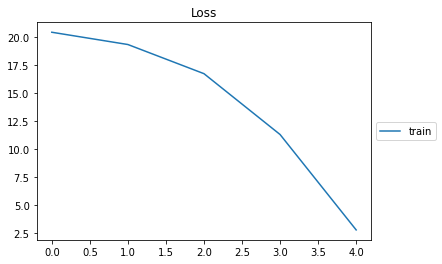

Init guess => mpiw: 1.1266885995864868; coverage_term: 15.868614196777344
Last values => mpiw: 2.7500405311584473; coverage_term: 0.0


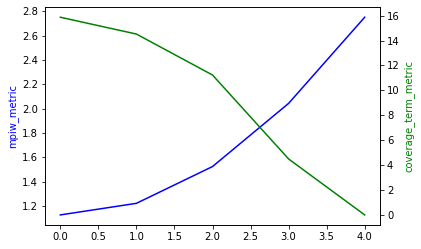

Init guess => mpiw: 1.1266885995864868; picp: 0.03351818025112152
Last values => mpiw: 2.7500405311584473; picp: 0.9582106471061707


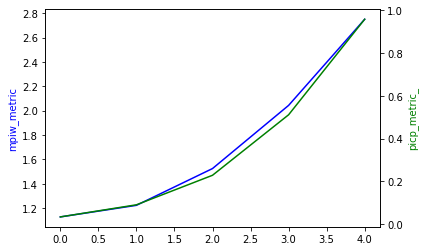

In [33]:
graph_pi_report(result)

## Quantile regressor 

Disanbiquation:

Linear Quantile Regressor (Statistics)
* alternative to linear regression when there is Heteroscedasticity. Can be seen as generalization of Lnear regression
assumptions (https://stats.stackexchange.com/questions/320991/what-are-the-assumptions-for-applying-a-quantile-regression-model)
* no assumtions about the target distributions (**The main motivation**)
* linearity of the coeficients (LighGBM does not have this assumtions)
* independence of observations
* very large sample size, as quantile regression is not very efficient
* y is "very" continuos


LightGBM quantile regressor (Machine Learning)

* Quantile is used to predict intervals of target variable
* The main difference related to generic regression is the loss function:
pinball loss: pos slope is  and negative slope is  (https://www.lokad.com/pinball-loss-function-definition#:~:text=The%20pinball%20loss%20function%20is,forecast%20is%20a%20subtle%20problem.)
 * $\tau = 0.5$ the loss is symetric
 * $\tau < 0.5$ penalizes more the positive error (see inclimation of the loss)
 * $\tau > 0.5$ penalizes more the negative side
* based on R doc: https://astrostatistics.psu.edu/datasets/R/html/quantreg/html/rq.html
    * $\tau$ is the quantile to be predict, so in python is 
* LIGHGBM $\alpha$ is the quantile we want to predict

## Boostrap 

## Compare 

* same data 